# Import Libraries

In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import math

# Load Data

### Import Load Data Functions

In [2]:
from LoadData import *

### Load Data and Preprocess

In [3]:
# load images
train_images, train_labels = load_data('training-a', 'training-a.csv')
train_images, train_labels = preprocess_data(train_images, train_labels)

# print shapes
print("train_images.shape = ", train_images.shape)
print("train_labels.shape = ", train_labels.shape)
print("train_images[0].shape = ", train_images[0].shape)

train_images.shape =  (1000, 28, 28, 1)
train_labels.shape =  (1000,)
train_images[0].shape =  (28, 28, 1)


### Split data into train and validation

In [4]:
# suffle data
s = np.arange(train_images.shape[0])
np.random.shuffle(s)
train_images = train_images[s]
train_labels = train_labels[s]

# split data into train and validation
train_ratio = 0.8
X_train = train_images[:int(train_ratio*len(train_images))]
y_train = train_labels[:int(train_ratio*len(train_labels))]
X_val = train_images[int(train_ratio*len(train_images)):]
y_val = train_labels[int(train_ratio*len(train_labels)):]

# Model

### Import Layers

In [5]:
from ConvolutionLayer import ConvolutionLayer
from ReLULayer import ReLULayer
from MaxPoolingLayer import MaxPoolingLayer
from FlattenLayer import FlattenLayer
from FullyConnectedLayer import FullyConnectedLayer
from SoftmaxLayer import SoftmaxLayer

### Import Model Class

In [6]:
from Model import Model

### Model Building

In [7]:
# use lenet-5 model
model = Model(10)
model.add(ConvolutionLayer(6, 5, 1, 1))
model.add(ReLULayer())
model.add(MaxPoolingLayer(pool_size=2, stride=2))
model.add(ConvolutionLayer(16, 5, 1, 1))
model.add(ReLULayer())
model.add(MaxPoolingLayer(pool_size=2, stride=2))
model.add(FlattenLayer())
model.add(FullyConnectedLayer(output_size=120))
model.add(ReLULayer())
model.add(FullyConnectedLayer(output_size=84))
model.add(ReLULayer())
model.add(FullyConnectedLayer(output_size=10))
model.add(SoftmaxLayer())

### Train Model

In [8]:
# train
model.train(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, learning_rate=0.000001, epochs=10, batch_size=64)

epoch:  0
y_pred (first 10)	:  [6 7 0 7 0 7 1 0 0 6]
y_real (first 10)	:  [0 5 3 1 2 4 7 8 9 4]
accuracy:  0.11
f1 score:  0.10168528418743268
epoch:  1
y_pred (first 10)	:  [6 7 4 6 1 4 9 8 0 8]
y_real (first 10)	:  [0 5 3 1 2 4 7 8 9 4]
accuracy:  0.12
f1 score:  0.11451283730798623
epoch:  2
y_pred (first 10)	:  [6 7 8 4 0 4 1 8 8 5]
y_real (first 10)	:  [0 5 3 1 2 4 7 8 9 4]
accuracy:  0.165
f1 score:  0.1489997179029437
epoch:  3
y_pred (first 10)	:  [8 7 4 5 0 4 6 3 8 5]
y_real (first 10)	:  [0 5 3 1 2 4 7 8 9 4]
accuracy:  0.225
f1 score:  0.22181800317026035
epoch:  4
y_pred (first 10)	:  [8 7 4 5 0 4 3 8 8 5]
y_real (first 10)	:  [0 5 3 1 2 4 7 8 9 4]
accuracy:  0.225
f1 score:  0.22561390274651033
epoch:  5
y_pred (first 10)	:  [8 4 4 5 0 4 8 8 8 4]
y_real (first 10)	:  [0 5 3 1 2 4 7 8 9 4]
accuracy:  0.28
f1 score:  0.26854354421239446
epoch:  6
y_pred (first 10)	:  [0 4 4 5 0 4 3 8 8 4]
y_real (first 10)	:  [0 5 3 1 2 4 7 8 9 4]
accuracy:  0.285
f1 score:  0.27744247643141

### Save Model

In [9]:
# Save the model using pickle
import pickle
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Load the model using pickle
with open('model.pkl', 'rb') as f:
    model = pickle.load(f)


## Performace Metrics and Confusion Matrix

### Load Test Data

In [10]:
# load test images
test_images, test_labels = load_data('training-d', 'training-d.csv')
test_images, test_labels = preprocess_data(test_images, test_labels)

### Performance Matrics

In [11]:
# performance metrics and confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# predict   
y_pred = model.predict(test_images)

# print performance metrics
print("Accuracy: ", accuracy_score(test_labels, y_pred))
print("Confusion Matrix: ", confusion_matrix(test_labels, y_pred))

# print classification report
print("Classification Report: ", classification_report(test_labels, y_pred))

Accuracy:  0.199
Confusion Matrix:  [[35 15  6  4  2  4  8  1 14 12]
 [17 18 12  4  5  3  9 15  9  8]
 [19 15 13  2  5  5  5  8  3 24]
 [17  4  3 31  4  4  6 16  5 14]
 [ 6  4  0 12  7 23  9 22  7  7]
 [11 10  7 22  4 10 11 12  8 10]
 [ 6 17  5  8  6  4 11 14  1 15]
 [ 7  7  3  5  9  4  3 39  3 19]
 [ 7  5 14  8  5 17  9  8 18  9]
 [20 12  4 10  4  4 12 13 12 17]]
Classification Report:                precision    recall  f1-score   support

           0       0.24      0.35      0.28       101
           1       0.17      0.18      0.17       100
           2       0.19      0.13      0.16        99
           3       0.29      0.30      0.30       104
           4       0.14      0.07      0.09        97
           5       0.13      0.10      0.11       105
           6       0.13      0.13      0.13        87
           7       0.26      0.39      0.32        99
           8       0.23      0.18      0.20       100
           9       0.13      0.16      0.14       108

    accuracy 

### Confustion Matrix

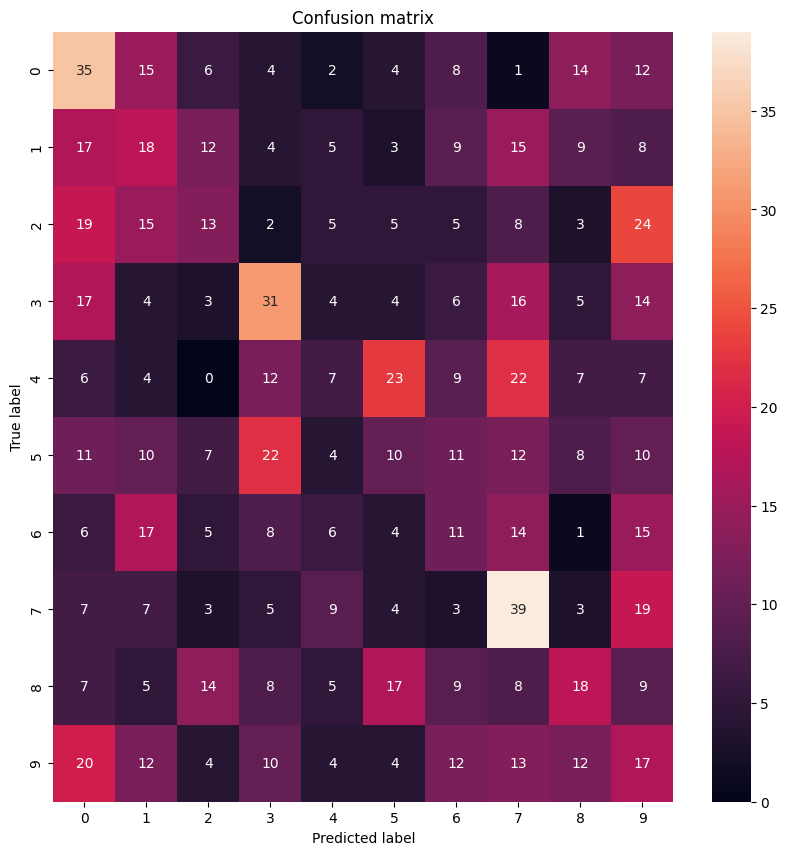

In [12]:
# plot confusion matrix using seaborn
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()